<!--BOOK_INFORMATION-->
<img align="left" src="" style="width: 76px; height: 100px; background: white; border: 1px solid black; margin-right:10px;">
*This notebook contains an excerpt from the upcoming book Machine Learning for OpenCV by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://github.com/mbeyeler/opencv-machine-learning)!*

<!--NAVIGATION-->
< [None](07.00-Implementing-a-Spam-Filter-with-Bayesian-Learning.ipynb) | [Contents](../README.md) | [None](09.00-Using-Deep-Learning-to-Classify-Handwritten-Digits.ipynb) >

# Understanding k-means clustering

## Introducing k-means

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

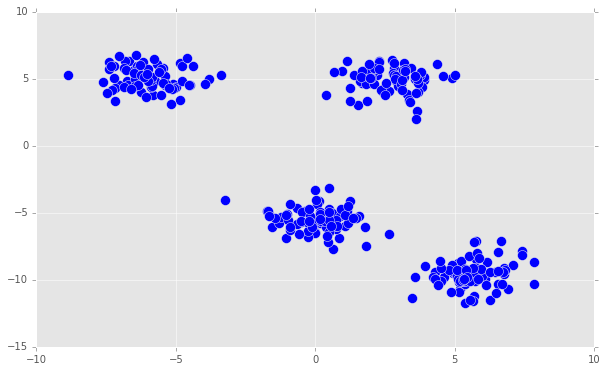

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=1.0, random_state=10)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=100);
plt.savefig('clusters.png')

In [3]:
import cv2

# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS

In [4]:
import numpy as np
compactness, labels, centers = cv2.kmeans(X.astype(np.float32), 4, None, criteria, 10, flags)

In [5]:
compactness

527.01581170992

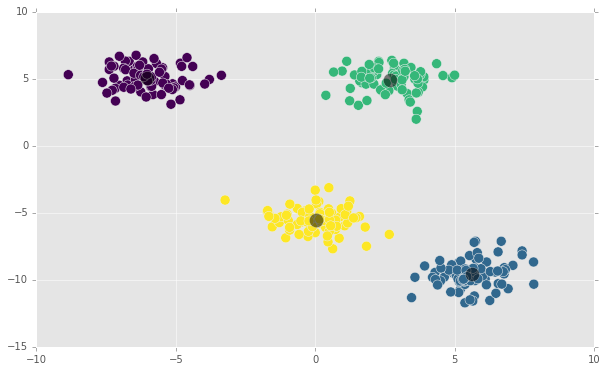

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.savefig('kmeans.png')

## Expectation Maximization

In [7]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=5):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

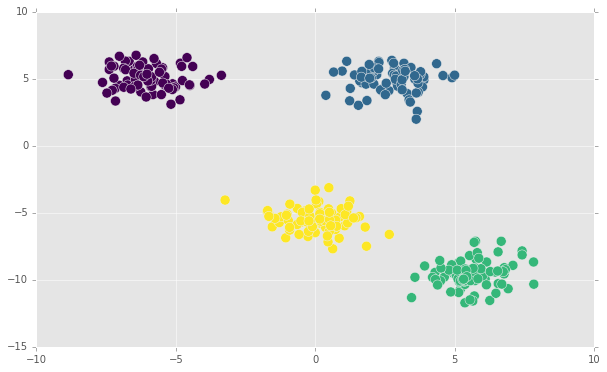

In [8]:
centers, labels = find_clusters(X, 4)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis');
plt.savefig('em.png')

## Caveats: might miss the global optimum

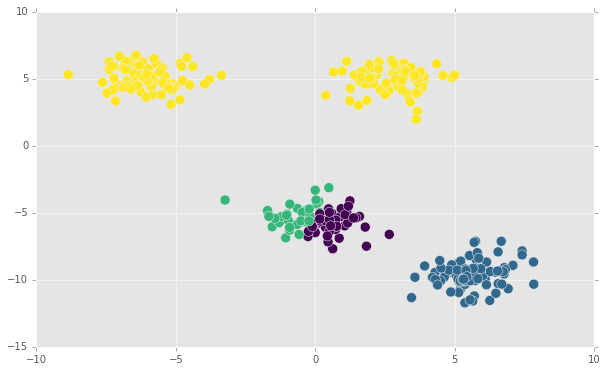

In [9]:
centers, labels = find_clusters(X, 4, rseed=10)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis');
plt.savefig('suboptimal.png')

## Caveats: must select number of clusters beforehand

In [10]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(X.astype(np.float32), 6, None, criteria, 10, flags)

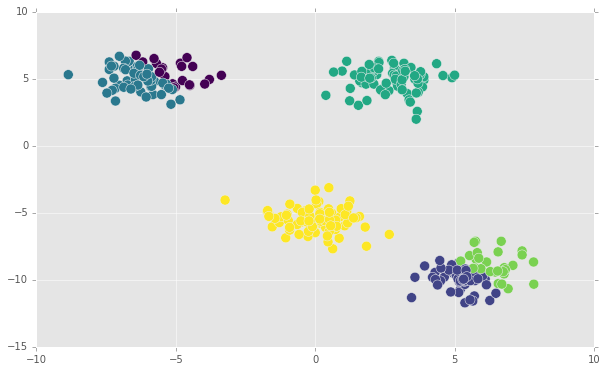

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis');
plt.savefig('wrong-number-of-clusters.png')

## Caveats: linear cluster boundaries

In [12]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=12)

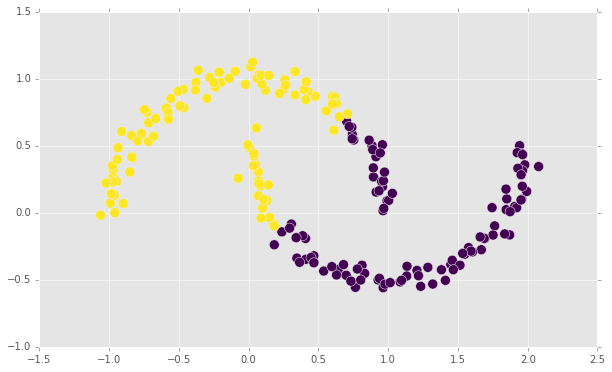

In [13]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(X.astype(np.float32), 2, None, criteria, 10, flags)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis');
plt.savefig('linear-boundaries.png')

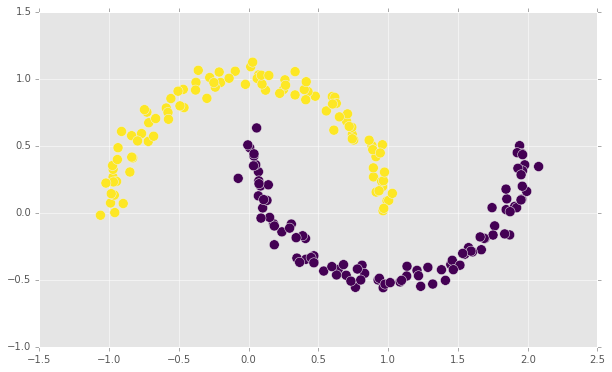

In [14]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=100, cmap='viridis');
plt.savefig('spectral.png')

<!--NAVIGATION-->
< [None](07.00-Implementing-a-Spam-Filter-with-Bayesian-Learning.ipynb) | [Contents](../README.md) | [None](09.00-Using-Deep-Learning-to-Classify-Handwritten-Digits.ipynb) >